# Install and import libraries

In [1]:
# Install libraries
'''
#%pip install pydub
%pip install librosa
%pip install -q evaluate transformers==4.28.1
%pip install -U -q datasets
%pip install -q torchaudio==0.12
#%add-apt-repository -y ppa:savoury1/ffmpeg4 
#%apt-get -qq install -y ffmpeg
%pip install -q mlflow
%pip install soundfile
'''

'\n#%pip install pydub\n%pip install librosa\n%pip install -q evaluate transformers==4.28.1\n%pip install -U -q datasets\n%pip install -q torchaudio==0.12\n#%add-apt-repository -y ppa:savoury1/ffmpeg4 \n#%apt-get -qq install -y ffmpeg\n%pip install -q mlflow\n%pip install soundfile\n'

In [2]:
# Import libraries
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
import torch
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from torchvision import transforms

import librosa
import librosa.display
from pathlib import Path
import matplotlib.pyplot as plt
import os

# Read csv files

In [3]:
# Read csv files for train and test data
df_train = pd.read_csv(f"archive\Metadata_Train.csv")
df_test = pd.read_csv(f"archive\Metadata_Test.csv")

# Change spelling mistake
df_test['Class'] = df_test['Class'].replace({"Sound_Guiatr": "Sound_Guitar"})

# Remove violin label as it is contaminated by Drums
df_train = df_train[df_train['Class']!="Sound_Violin"]
df_test = df_test[df_test['Class']!="Sound_Violin"]

# Show sample of DataFrame
df_train.head()

,FileName,Class
0,1-E1-Major 00.wav,Sound_Guitar
1,1-E1-Major 01.wav,Sound_Guitar
2,1-E1-Major 02.wav,Sound_Guitar
3,1-E1-Major 03.wav,Sound_Guitar
4,1-E1-Major 04.wav,Sound_Guitar


In [4]:
# Show sample of DataFrame
df_test.head()

,FileName,Class
0,acoustic-guitar-logo-13084.wav,Sound_Guitar
1,guitar-chords-70663.wav,Sound_Guitar
2,guitar-intro-110935.wav,Sound_Guitar
3,guitar-solo-27194.wav,Sound_Guitar
4,guitar-solo-5999.wav,Sound_Guitar


# Visualize data contents

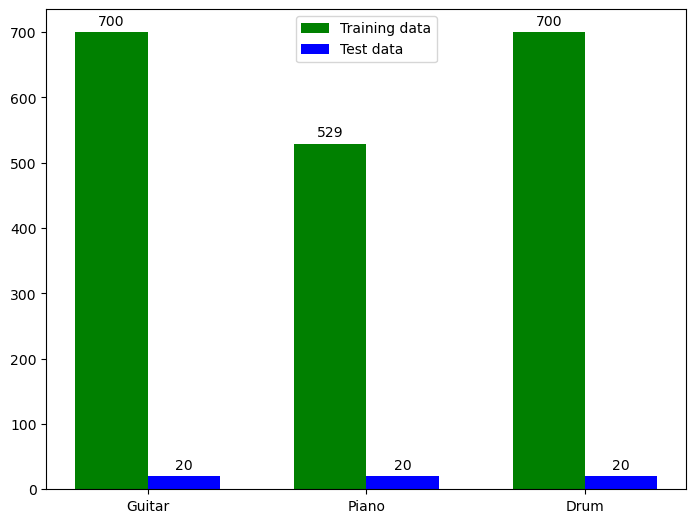

In [5]:
# List of labels
instruments = ('Guitar', 'Piano', 'Drum')
xticks = np.arange(len(instruments))

# Count the files of each class.
occurences_test = [df_test['Class'].value_counts()['Sound_Guitar'], 
                  df_test['Class'].value_counts()['Sound_Piano'], 
                  df_test['Class'].value_counts()['Sound_Drum']]

occurences_train = [df_train['Class'].value_counts()['Sound_Guitar'], 
                    df_train['Class'].value_counts()['Sound_Piano'], 
                    df_train['Class'].value_counts()['Sound_Drum']]

# Plot bar graph
width = 0.33
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
bar_train = ax.bar(xticks - width/2, occurences_train, color = 'g', width = width)
bar_test = ax.bar(xticks + width/2, occurences_test, color = 'b', width = width)
ax.legend(labels=['Training data', 'Test data'])
ax.set_xticks(xticks, instruments)

# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bar_train)
autolabel(bar_test)

plt.show()

# Add filepaths to DataFrame

In [6]:
# Go through the data and add the filenames and filepaths to the sound files.
# Note that the parameter filepath is after the folder archive.
# Function inspired by https://www.kaggle.com/code/dima806/musical-instrument-detection
def load_data(filepath):
    file_list = []
    sample_list = []
    for file in Path('archive/').glob(filepath):
        sample_name = file.stem + '.wav'
        file_list.append(file)
        sample_list.append(str(sample_name))
    dd = pd.DataFrame()
    dd['file'] = file_list
    dd['FileName'] = sample_list
    return dd

In [7]:
# Collect filepaths for train data.
dd_train = load_data('Train_submission\Train_submission\*.wav')
# Join with train DataFrame that has the classes.
dd_train = dd_train.set_index('FileName').join(df_train.set_index('FileName'), how='inner')
# Keep only file and class columns (discard filename)
selected_cols = ['file', 'Class']
dd_train = dd_train[selected_cols]

# Reset indices and display.
dd_train = dd_train.reset_index(drop=True)
dd_train.head()

,file,Class
0,archive\Train_submission\Train_submission\0295...,Sound_Piano
1,archive\Train_submission\Train_submission\0355...,Sound_Piano
2,archive\Train_submission\Train_submission\04-4...,Sound_Drum
3,archive\Train_submission\Train_submission\0465...,Sound_Drum
4,archive\Train_submission\Train_submission\0543...,Sound_Drum


In [8]:
# Collect filepaths and join it with the classes in the previously made DataFrame for the test data,
# as done for training data above.
dd_test = load_data('Test_submission\Test_submission\*.wav')
dd_test = dd_test.set_index('FileName').join(df_test.set_index('FileName'), how='inner')
selected_cols = ['file', 'Class']
dd_test = dd_test[selected_cols]
dd_test = dd_test.reset_index(drop=True)
dd_test.head()

,file,Class
0,archive\Test_submission\Test_submission\100bpm...,Sound_Drum
1,archive\Test_submission\Test_submission\acoust...,Sound_Guitar
2,archive\Test_submission\Test_submission\darbuk...,Sound_Drum
3,archive\Test_submission\Test_submission\guitar...,Sound_Guitar
4,archive\Test_submission\Test_submission\guitar...,Sound_Guitar


# Display sound files

In [9]:
# Borrowed from https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html
# Function to display a waveform
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
              axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
              axes[c].set_xlim(xlim)
        if ylim:
              axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)
    
# Borrowed from https://pytorch.org/audio/main/tutorials/audio_feature_extractions_tutorial.
# html#sphx-glr-tutorials-audio-feature-extractions-tutorial-py
# Function to display a spectrogram
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(specgram, origin="lower", aspect="auto", interpolation="nearest")

In [10]:
# Simple function to open an audiofile from the filepath
def open(audio_file):
    # TODO: Later, the load function can also be used to set the sampling rate and the time of the clip to be used
    sig, sr = librosa.load(audio_file)
    return (sig, sr)

# Creates and displays a Mel spectrogram (use open() first)
def display_mel(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig, fs = aud
    plt.axis('off') # no axis
    plt.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
    S = librosa.feature.melspectrogram(y=sig, sr=fs)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    plt.show()
    return

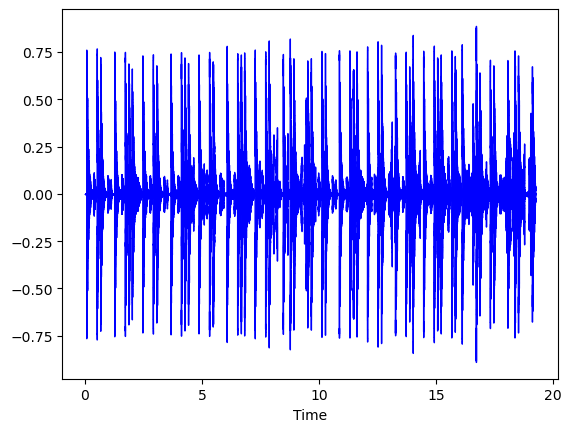

In [11]:
# Example of waveform graph.
y,sr=librosa.load('archive/Test_submission/Test_submission/100bpm-808-like-drum-loop-74838.wav') #load the file
librosa.display.waveshow(y,sr=sr, axis='time', color='blue')

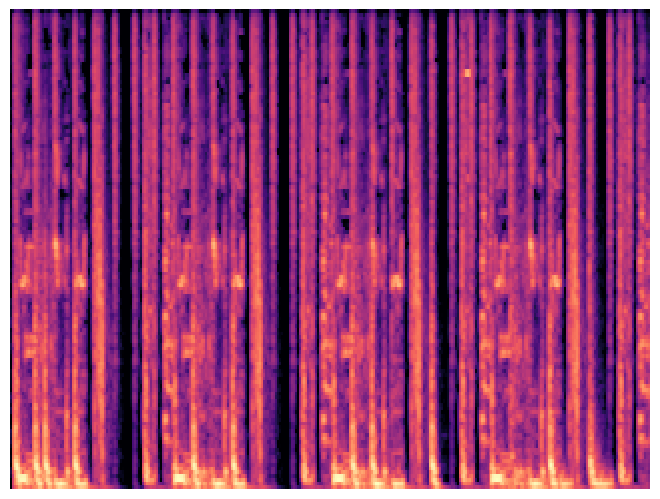

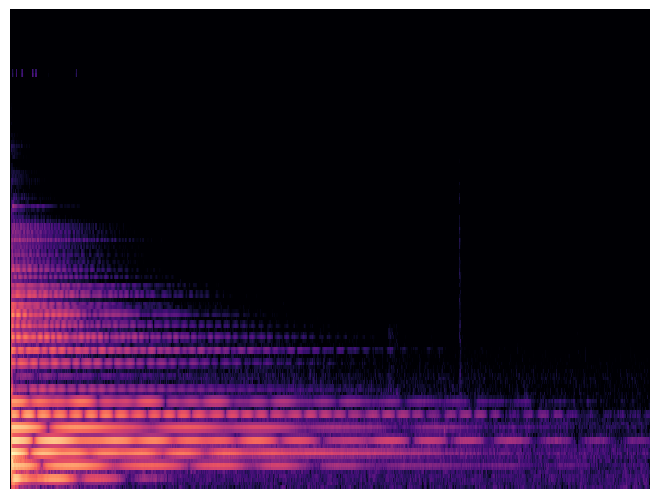

In [12]:
# Examples of Mel spectrograms.
sig, fs = open(dd_train['file'][2])
display_mel((sig,fs))

sig, fs = open(dd_train['file'][1])
display_mel((sig,fs))

# Saving images

In [13]:
# Function that splits a DataFrame into the separate instrument classes.
def split_data(df):
    dd_guitar = df[df['Class'] == 'Sound_Guitar']
    dd_piano = df[df['Class'] == 'Sound_Piano']
    dd_drum = df[df['Class'] == 'Sound_Drum']
    classlist = [dd_guitar, dd_piano, dd_drum]
    return classlist

# Shuffle training data (to separate better into validation-training parts).
dd_train = dd_train.sample(frac=1).reset_index(drop=True)

# Make part of the training data validation data (~10%)
dd_val = pd.DataFrame(columns=dd_train.columns)
rows = dd_train[:200]
dd_val = pd.concat([dd_val, rows], ignore_index=True)
dd_train.drop(rows.index, inplace=True)

# Create lists of data for each type (test, val, train) with each class.
class_list_train = split_data(dd_train)
class_list_val = split_data(dd_val)
class_list_test = split_data(dd_test)

folder_names = ['guitar', 'piano', 'drum']

In [14]:
def save_images(folder_name, folder_names, class_list, method):

    # Create directories
    if not os.path.exists(folder_name):
           os.makedirs(folder_name)
    for folder in folder_names:
        if not os.path.exists(folder_name + '/'+ folder + '/' + method):
            os.makedirs(folder_name + '/' + folder + '/' + method)

    # Create and save the image type based on method parameter
    for i, category in enumerate(folder_names):
        for j, file in enumerate(class_list[i]['file']):
            y, sr = librosa.load(file)
            plt.axis('off') # no axis
            plt.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
            if method == 'wave':
                librosa.display.waveshow(y,sr=sr, axis='time', color='blue')
                plt.savefig(folder_name + '/'+ category + '/' + method + '/wave{}'.format(j) + '.jpg')
            elif method == 'chroma':
                S = librosa.feature.chroma_cqt(y=y, sr=sr)
                librosa.display.specshow(S)
                plt.savefig(folder_name + '/'+ category + '/' + method +'/chroma{}'.format(j)+'.jpg')
            elif method == 'mel':
                S = librosa.feature.melspectrogram(y=y, sr=sr)
                librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
                plt.savefig(folder_name + '/'+ category + '/' + method + '/mel{}'.format(j) + '.jpg')
            else:
                S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=512)
                librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
                plt.savefig(folder_name + '/'+ category + '/' + method + '/melFFT{}'.format(fj)+'.jpg')
            plt.close()

# Change last parameter to change image type that is saved.        
save_images('train', folder_names, class_list_train, 'mel')
save_images('test', folder_names, class_list_test, 'mel')
save_images('val', folder_names, class_list_val, 'mel')